In [2]:
"""
Magic commands
"""
%matplotlib inline
%load_ext autoreload
%autoreload 2

"""
Python standard packages
"""
import os
import sys

import numpy as np
import pandas as pd


import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, clear_output

import scipy.stats as stats
import random
from statsmodels.tsa.stattools import acf
import statsmodels.api as sm
"""
Own packages
"""
sys.path.insert(0, "C:\\code\\speciale\\") # vesl path
sys.path.insert(0, "C:\\Users\\lucas\\OneDrive\\Skrivebord\\repo\\speciale\\") # ljb path

from market_simulation_study.agent import RandomAgent, InvestorAgent, TrendAgent, RLAgent, MarketMakerAgent
from market_simulation_study.environment import MarketEnvironment

from codelib.plotting import dist_vs_normal_plot, volume_contribution_plot, DefaultStyle, default_colors
sns.set_theme("paper","whitegrid")
DefaultStyle()
"""
Initializations
"""
pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', None)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
import warnings
warnings.filterwarnings('ignore')

# Simulation 


## Setup

In [61]:
# Declare parameters
n_random_agents = 4
n_investor_agents = 2
n_trend_agents = 4
n_mm_agents = 15
n_rl_agents = 0

n_agents = n_random_agents + n_investor_agents + n_trend_agents + n_rl_agents + n_mm_agents

time_periods = 1000

price_list = [100 + np.random.normal(scale = 0.01) for j in range(100)]
ex_list = np.array([[0]*n_agents, [0]*n_agents])
fee = 0
slippage = 0
mean_buy_price = 99.5
mean_sell_price = 100.5
delta = 1
atp = 0

state0 = {"market_prices": price_list, "volume": ex_list, 'fee': fee, "mean_buy_price": mean_buy_price,
          "mean_sell_price": mean_sell_price, 'slippage': slippage, 'all_traded_prices': atp}

agents = []

investor_agents = []

inv_intensity = 0.02

if n_investor_agents >= 1:
    investor_agents.append(InvestorAgent(agent_id = 0,
                                     delta = delta,
                                     intensity = inv_intensity / 4,
                                     buy_price_margin = 0.0025,
                                     sell_price_margin = 0.010,
                                     buy_volume = 15,
                                     sell_volume = 30, 
                                     n_orders = 10))
if n_investor_agents == 2:  
    investor_agents.append(InvestorAgent(agent_id = 1,
                                         delta = delta,
                                         intensity = inv_intensity / 2,
                                         n_orders = 6,
                                         buy_price_margin  = 0.005,
                                         sell_price_margin = 0.020,
                                         buy_volume = 25,
                                         sell_volume = 50,
                                         can_short = True))

random_agents = [RandomAgent(agent_id = j + n_investor_agents,
                             delta = delta,
                             noise_range = (0.0001, 0.0003),
                             mid_price_noise = 0.0025,
                             n_coin_flips = 3, 
                             coin_bias_sell = 0.5,
                             coin_bias_buy = 0.5) for j in range(n_random_agents)]

trend_agents = [TrendAgent(agent_id = j + n_random_agents + n_investor_agents,
                                 delta = delta,
                                  moving_average_one = np.random.randint(10, 15),
                                  moving_average_two = np.random.randint(20, 30),
                                  price_margin = 0.005) for j in range(n_trend_agents)]

mm_agents = [MarketMakerAgent(agent_id = j + n_random_agents + n_investor_agents + n_trend_agents,
                              delta = delta,
                              gamma = 0.00005,
                              gamma2 = np.random.uniform(0.5, 0.75), #np.random.randint(1, 1),
                              spread_zero = np.random.uniform(0.1, 0.1), 
                              n_volume = 3) for j in range(n_mm_agents)]

rl_agents = [RLAgent(agent_id = j + n_random_agents + n_investor_agents + n_trend_agents + mm_agents,
                                 delta = delta) for j in range(n_rl_agents)]

agents.append(investor_agents)
agents.append(random_agents)
agents.append(trend_agents)
agents.append(mm_agents)
agents.append(rl_agents)

TypeError: Can't instantiate abstract class RLAgent with abstract method reset

### Initialize agents

In [28]:
env = MarketEnvironment(state0, use_last_traded_price = True)

agents = [item for sublist in agents for item in sublist]

# Initialize agents
for j in range(n_agents):
        agents[j].update(state0)

## Run simulation

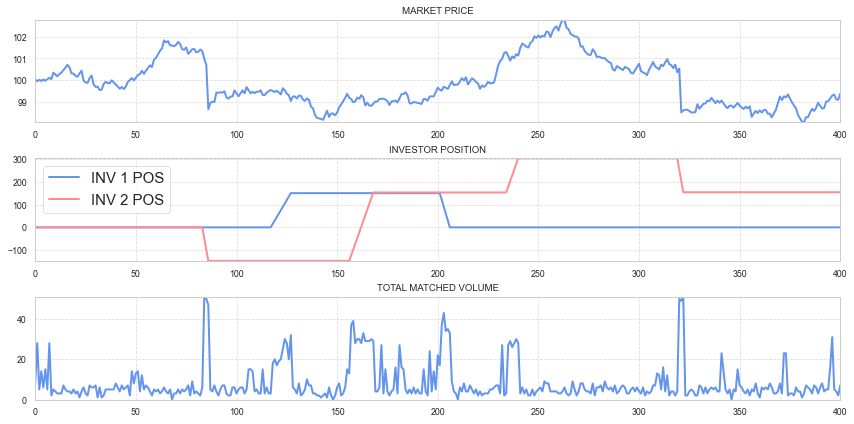

                                                         EPISODE 0 - 100%                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

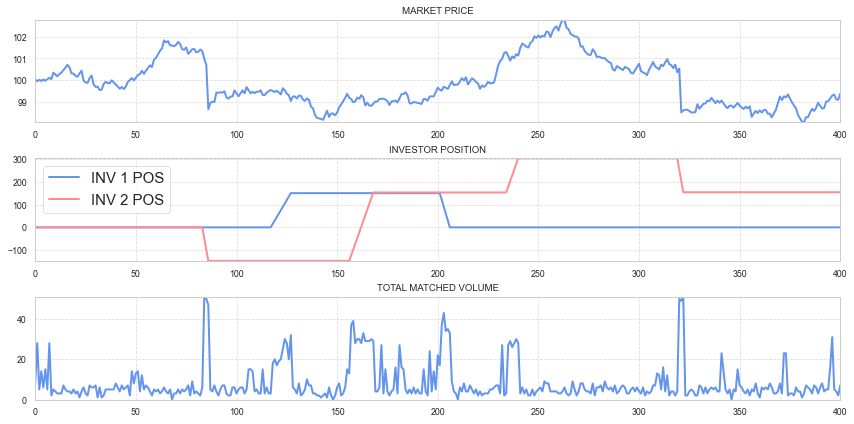

In [30]:
time_periods = 500
n_episodes = 1
rl_profit = []
market_prices = []
inv1_pos = []
inv2_pos = []
market_volume = []
atps = np.array([np.nan])
stack_autocorrels = True

save_count = 10
mm_volumes = np.zeros(int(time_periods / save_count))
random_volumes = np.zeros(int(time_periods / save_count))
investor_volumes = np.zeros(int(time_periods / save_count))
trend_volumes = np.zeros(int(time_periods / save_count))

mm_pnls = np.zeros(int(time_periods / save_count))
random_pnls = np.zeros(int(time_periods / save_count))
investor_pnls = np.zeros(int(time_periods / save_count))
trend_pnls = np.zeros(int(time_periods / save_count))

bps = []
sps = []

fig, ax = plt.subplots(3, 1, figsize = (12, 6))
fig.tight_layout()
for episode in range(n_episodes):
    env = MarketEnvironment(state0, use_last_traded_price = True)
    # Initialize agents
    for j in range(n_agents):
            agents[j].reset()
            agents[j].update(state0)
            
    # START EPISODE
    for time in range(time_periods):

        agents, state = env.step(agents)

        for j in range(n_agents):
            agents[j].update(state)


        ########################################
        # PRINT RUNTIME
        ########################################

        j = (time + 1) / time_periods
        sys.stdout.write('\r'.center(65))
        sys.stdout.write(f"EPISODE {episode} - %d%%".center(65) % (100*j))
        sys.stdout.flush()
        
        #########################################
        # SAVE VOLUMES
        #########################################

        if save_count:
            
            if time % save_count == 0:
                for agent in agents:
                    agent.calculate_profit_and_loss(state)
                    if agent.agent_class == "MM":
                        mm_volumes[int(time / save_count)] += np.abs(agent.all_trades[:, 1]).sum()
                        mm_pnls[int(time / save_count)] += agent.pnl
                    elif agent.agent_class == "Random":
                        random_volumes[int(time / save_count)] += np.abs(agent.all_trades[:, 1]).sum()
                        random_pnls[int(time / save_count)] += agent.pnl
                    elif agent.agent_class == "Investor":
                        investor_volumes[int(time / save_count)] += np.abs(agent.all_trades[:, 1]).sum()
                        investor_pnls[int(time / save_count)] += agent.pnl
                    elif agent.agent_class == "Trend":
                        trend_volumes[int(time / save_count)] += np.abs(agent.all_trades[:, 1]).sum()
                        trend_pnls[int(time / save_count)] += agent.pnl
            
        #########################################
        # UPDATE PLOTS
        #########################################

        inv1_pos.append(agents[0].position)
        inv2_pos.append(agents[1].position)
        market_volume.append(state["volume"])
        market_prices.append(state["market_prices"][-1])
        atps = np.hstack((atps, state["all_traded_prices"]))
        bps.append(agents[-1].buy_price)
        sps.append(agents[-1].sell_price)
        
        if time % 100 == 0:
            clear_output()
            ax[0].cla()
            ax[0].plot(market_prices)
            #ax[0].plot(atps)
            ax[0].set(title = "MARKET PRICE")

            ax[1].cla()
            ax[1].set(title = "INVESTOR POSITION")
            ax[1].plot(inv1_pos, label = "INV 1 POS")
            ax[1].plot(inv2_pos, label = "INV 2 POS")
            ax[1].legend()

            ax[2].cla()
            ax[2].set(title = "TOTAL MATCHED VOLUME")
            ax[2].plot(market_volume)

            display(fig)
    
    
    #########################################
    # END OF EPISODE
    #########################################
    if stack_autocorrels:
        mp = pd.DataFrame(atps)
        #mp = pd.DataFrame({"return": market_prices})
        returns = (mp / mp.shift(1)  - 1).dropna()
        #fig1, ax1 = plt.subplots()
        #ax1.set(xlim = (0, 10))
        if episode == 0:
            # Stack returns
            all_stacked_returns = returns.values.flatten()
            # stack autocorrels
            #autocorrel_returns = pd.plotting.autocorrelation_plot(returns, ax = ax1).get_yticks()
            #autocorrel_absreturns = pd.plotting.autocorrelation_plot(np.abs(returns[1:]), ax = ax1).get_yticks()
        else:
            # stack returns
            all_stacked_returns = np.hstack((all_stacked_returns, returns.values.flatten()))
            # stack autocorrels
            #temp_auto_returns = pd.plotting.autocorrelation_plot(returns, ax = ax1).get_yticks()
            #print("1", autocorrel_returns)
            #print("2", temp_auto_returns)
            #autocorrel_returns = np.vstack((autocorrel_returns, temp_auto_returns))
            #temp_auto_absreturns = pd.plotting.autocorrelation_plot(np.abs(returns[1:]), ax = ax1).get_yticks()
            #autocorrel_absreturns = np.vstack((autocorrel_absreturns, temp_auto_absreturns))
       # ax1.cla()
    
    
    
mm_volumes[1:] = mm_volumes[1:] - mm_volumes[:-1]
random_volumes[1:] = random_volumes[1:] - random_volumes[:-1]
investor_volumes[1:] = investor_volumes[1:] - investor_volumes[:-1]
trend_volumes[1:] = trend_volumes[1:] - trend_volumes[:-1]
total_volumes = mm_volumes + investor_volumes + trend_volumes + random_volumes

mm_volumes = mm_volumes / total_volumes
investor_volumes = investor_volumes / total_volumes
trend_volumes = trend_volumes / total_volumes
random_volumes = random_volumes / total_volumes

stacked_volumes = np.vstack((investor_volumes, trend_volumes,random_volumes, mm_volumes))
stacked_pnls = np.vstack((investor_pnls / n_investor_agents, trend_pnls / n_trend_agents, random_pnls / n_random_agents, mm_pnls / n_mm_agents))
time_points = np.linspace(save_count, time_periods, int(time_periods / save_count))

#save_state_space
#agents[n_agents - 1].save_state_space()

[Text(0.5, 0, 'Time'), Text(0, 0.5, 'Cumulative Return')]

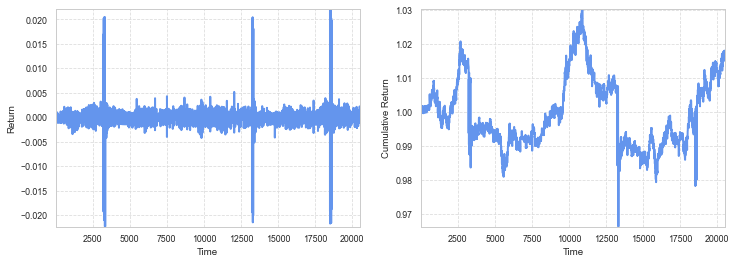

In [31]:
#mp = pd.DataFrame(market_prices[100:])
mp = pd.DataFrame(atps)
#mp = pd.DataFrame({"return": market_prices})
returns = (mp / mp.shift(1)  - 1).dropna() 
#returns = returns[abs(returns.values) <= 0.0125]
cum_ret = (returns + 1).cumprod()
fig, ax = plt.subplots(1, 2, figsize = (12, 4))

ax[0].plot(returns)
ax[0].set(ylabel = "Return", xlabel = "Time")
ax[1].plot(cum_ret)
ax[1].set(xlabel = "Time", ylabel = "Cumulative Return")

#plt.savefig("plots/returns_cumreturns_4.png")

# Stylized Facts Comparison

## returns

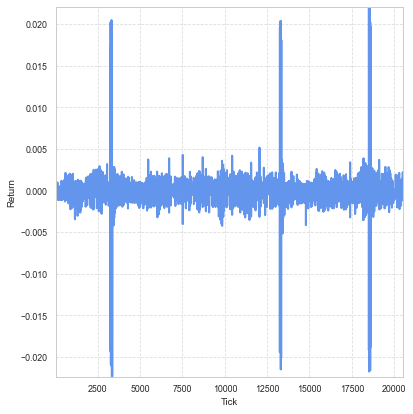

In [32]:
fig, ax = plt.subplots(figsize = (6, 6))
ax.plot(returns)
ax.set(ylabel = "Return", xlabel = "Tick")
#ax.set(xlim = (-0.005, 0.005))
fig.tight_layout()
#ret = "returns_bfrl_6"
#plt.savefig(f"plots/{ret}.png")

### Heavy Tails

In [33]:
all_stacked_returns.shape

(20523,)

In [34]:
from codelib.stats import weighted_kurtosis

In [35]:
test_data = pd.read_parquet('abm_calibration/ef805fd82ff54fadb363094e3b122ab9.parquet', engine='pyarrow')
test_data
spy_prices = test_data[["time_id", "price"]]
spy_prices = spy_prices.set_index("time_id", drop = True)
spy_returns = (spy_prices["price"] / spy_prices["price"].shift() - 1).dropna()

In [36]:
compare_returns = pd.DataFrame(spy_returns)
x_vals, y_vals = sns.kdeplot(x=returns.values.flatten(), color="cornflowerblue",
                                 weights=np.ones_like(returns.values.flatten()), label="Returns",
                                 alpha=1, ax=ax).get_lines()[0].get_data()
ax.cla()
x_vals2, y_vals2 = sns.kdeplot(x=compare_returns.values.flatten(), color="cornflowerblue",
                                       weights=np.ones_like(compare_returns.values.flatten()), label="Returns",
                                       alpha=1, ax=ax).get_lines()[0].get_data()

In [37]:
ax.cla()
x_vals2, y_vals2 = sns.kdeplot(x=compare_returns.values.flatten(), color="cornflowerblue",
                                       weights=np.ones_like(compare_returns.values.flatten()), label="Returns",
                                       alpha=1, ax=ax, gridsize = 500).get_lines()[0].get_data()

In [38]:
ax.cla()
x_vals, y_vals = sns.kdeplot(x=returns.values.flatten(), color="cornflowerblue",
                                 weights=np.ones_like(returns.values.flatten()), label="Returns",
                                 alpha=1, ax=ax, gridsize = 500).get_lines()[0].get_data()

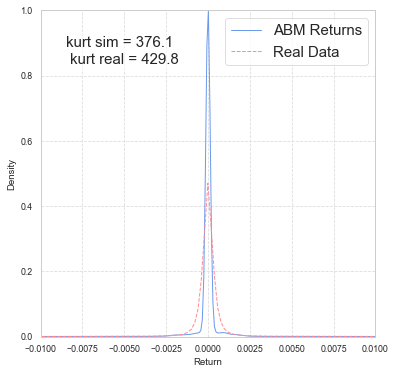

In [50]:
kurt = weighted_kurtosis(returns, wts=np.ones_like(returns))
kurt2 = weighted_kurtosis(compare_returns, wts = np.ones_like(compare_returns))
loc = [0.15, 0.9]


fig, ax = plt.subplots(figsize = (6, 6))
ax.set(xlim = (-0.01, 0.01))
ax.plot(x_vals, y_vals / y_vals.max(), lw = "1", alpha = 0.95, label = "ABM Returns")
ax.plot(x_vals2, y_vals2 / y_vals.max(), ls = "--", lw = "1", alpha = 1, label = "Real Data")

ax.text(loc[0]+0.085, loc[1], f"kurt sim = {kurt:.1f}", horizontalalignment='center', verticalalignment='center',
            transform=ax.transAxes, bbox=dict(facecolor='white', alpha=0.5))
ax.text(loc[0]+0.1, loc[1] - 0.05, f"kurt real = {kurt2:.1f}", horizontalalignment='center', verticalalignment='center',
        transform=ax.transAxes, bbox=dict(facecolor='white', alpha=0.5))
ax.legend()
ax.set(xlabel = "Return", ylabel = "Density")
#plt.savefig("plots/abm_compare_dist_ljb.png")

In [40]:
kurt

376.10059183269794

### Volatility Clustering

In [41]:
acf(abs(returns), nlags = 1)[1:]

array([0.27394849])

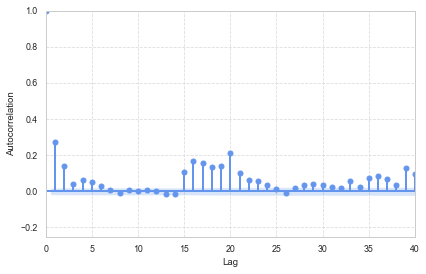

In [56]:
fig, ax = plt.subplots( figsize = (6, 4))
sm.graphics.tsa.plot_acf(np.abs(returns[1:]), lags = 40, ax = ax, alpha = 0.01)
fig.tight_layout()
ax.set(xlim = (0, 40), ylim = (-0.25, None), title = None, 
      xlabel = "Lag", ylabel = "Autocorrelation")
vol_clust_name = "vol_cluster_bfrl_8"
#plt.savefig(f"plots/{vol_clust_name}_ljb.png")

### Autocorrel of returns

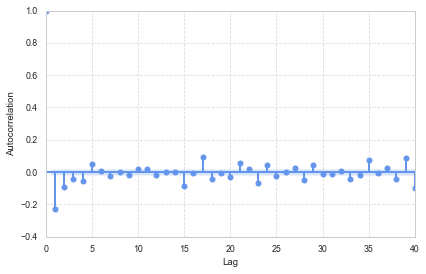

In [57]:
fig, ax = plt.subplots( figsize = (6, 4))
sm.graphics.tsa.plot_acf(returns[1:], lags = 40, ax = ax, alpha = 0.01)
fig.tight_layout()
ax.set(xlim = (0, 40), ylim = (-0.4, None), title = None, 
      xlabel = "Lag", ylabel = "Autocorrelation")
auto_ret_name = "auto_returns_bfrl_8"
#plt.savefig(f"plots/{auto_ret_name}_ljb.png")

# Volume Contribution

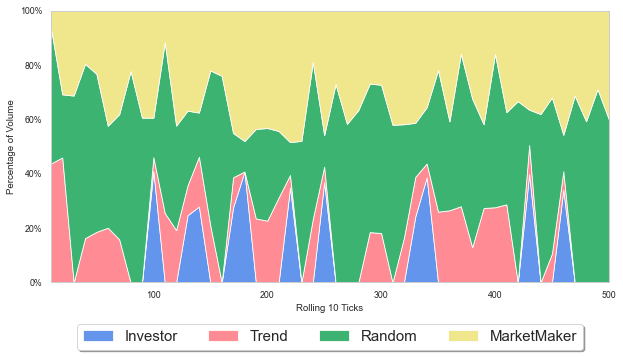

In [53]:
fig, ax = plt.subplots(figsize = (10, 5))
volume_contribution_plot(time_points, stacked_volumes, ax = ax, n_ticks = save_count)
volume_name = "volume_graph_6"
#plt.savefig(f"plots/{volume_name}_ljb.png")

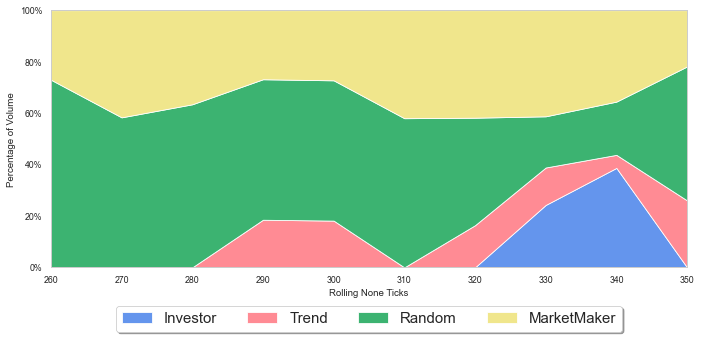

In [54]:
aa = 25
bb = 35

fig, ax = plt.subplots(figsize = (10, 5))
volume_contribution_plot(time_points[aa:bb], stacked_volumes[:, aa:bb], ax = ax, n_tick = save_count)
fig.tight_layout()
volume_name_zoom = "volume_graph_zoom_5"
#plt.savefig(f"plots/{volume_name_zoom}_ljb.png")

## Test MMS

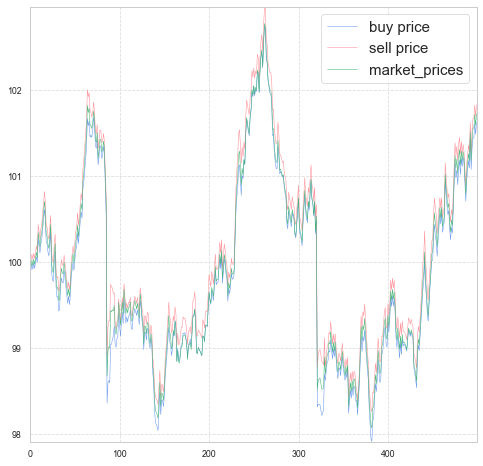

In [46]:
fig, ax = plt.subplots(figsize = (8, 8))
ax.plot(bps, label = "buy price", lw = 0.5)
ax.plot(sps, label = "sell price", lw = 0.5)
ax.plot(state["market_prices"][100:], label = "market_prices", lw = 0.5)
ax.legend()
#ax.set_xlim(200, 250)
#ax.set_ylim(108, 110)

<AxesSubplot:>

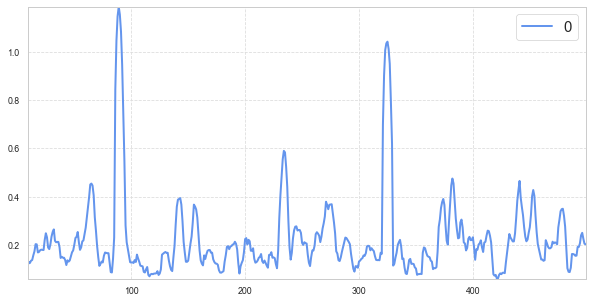

In [47]:
fig, ax = plt.subplots(figsize = (10, 5))
pd.DataFrame(state["market_prices"][100:]).rolling(window = 10).std().plot(ax = ax)

# PnL

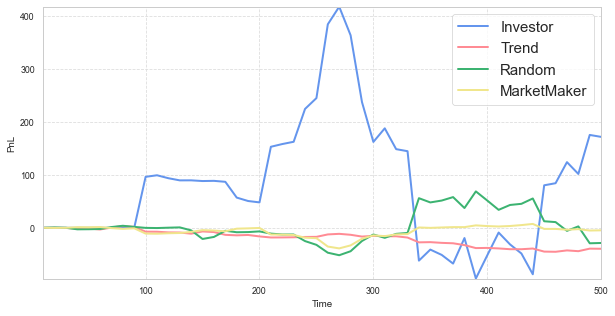

In [55]:
fig, ax = plt.subplots(figsize = (10, 5))
labs = ["Investor", "Trend", "Random", "MarketMaker"]
for j in range(4):
    ax.plot(time_points, stacked_pnls[j, :], label = labs[j])
ax.set(xlabel = "Time", ylabel = "PnL")
ax.legend()
#plt.savefig("plots/pnl_bfrl_ljb.png")

# Performance overview

In [49]:
stats_df = pd.DataFrame({"id":None, "class":None, "Position":None, "PNL":None}, index = [0]).dropna()
for agent in agents:
    agent.calculate_profit_and_loss(state)
    df_temp = pd.DataFrame({"id": agent.agent_id,
                            "class":agent.agent_class, 
                            "Position":agent.position, 
                            "PNL": agent.pnl, 
                            "latency": agent.latency},
                            index = [agent.agent_id])
    #stats_df = stats_df.append(df_temp)
    stats_df = pd.concat([stats_df, df_temp])

print("PNL SUM: ", stats_df["PNL"].sum())
print("POS SUM: ", stats_df["Position"].sum())
stats_df.sort_values("latency", inplace = True)
#np.corrcoef(stats_df.PNL, stats_df.latency)
display(stats_df)
display(stats_df.groupby("class")["PNL"].mean())

PNL SUM:  -5.115907697472721e-13
POS SUM:  0.0


,id,class,Position,PNL,latency
11,11,MM,-3.0,-13.934678,0.564347
13,13,MM,-3.0,-7.807348,0.588165
22,22,MM,0.0,-0.304618,0.599124
17,17,MM,-1.0,-0.44299,0.609704
15,15,MM,-2.0,-10.255569,0.646185
10,10,MM,-1.0,9.81886,0.661690
21,21,MM,1.0,9.197873,0.666733
14,14,MM,-1.0,-1.6188,0.691579
20,20,MM,-1.0,-4.487562,0.695156
19,19,MM,-2.0,-5.234043,0.708574


class
Investor    207.969058
MM           -5.403146
Random      -46.415759
Trend       -37.306973
Name: PNL, dtype: float64